In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 121.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 62.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: requests
    Found existing installation: requests 2.32.5
    Uninstalling requests-2.32.5:
      Successfully uninstalled requests-2.32.5
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: matplotlib-inline
    Found existing installation: matplotlib-inline 0.1.7
    Uninstalling matplotlib-inline-0.1.7:
      Successfully uninstalled matplot

In [6]:
import collections
import re
import math
import torch
from d2l import torch as d2l
import torch.nn as nn
import torch.nn.functional as F

# 1. 文本预处理
def read_time_machine():
    d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                    '090b5e7e70c295757f55df93cb0a180b9691891a')
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='char'):
    return [list(line) for line in lines] if token == 'char' else [line.split() for line in lines]

class Vocab:
    def __init__(self, tokens=None):
        counter = collections.Counter([tk for line in tokens for tk in line] if isinstance(tokens[0], list) else tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx_to_token = ['<unk>'] + [token for token, freq in self.token_freqs]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    def __len__(self): return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)): return self.token_to_idx.get(tokens, 0)
        return [self[token] for token in tokens]

# --- 核心修复：定义一个可以反复使用的 DataLoader 类 ---
class TimeMachineLoader:
    def __init__(self, batch_size, num_steps, max_tokens=10000):
        lines = read_time_machine()
        tokens = tokenize(lines, 'char')
        self.vocab = Vocab(tokens)
        self.corpus = [self.vocab[token] for line in tokens for token in line]
        if max_tokens > 0: 
            self.corpus = self.corpus[:max_tokens]
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_batches = (len(self.corpus) - 1) // (batch_size * num_steps)

    def __iter__(self):
        # 每次迭代时，重新生成一个新的 offset 和数据流
        offset = 0 
        for i in range(self.num_batches):
            X = torch.tensor(self.corpus[offset : offset + self.batch_size * self.num_steps]).reshape(self.batch_size, self.num_steps)
            Y = torch.tensor(self.corpus[offset + 1 : offset + self.batch_size * self.num_steps + 1]).reshape(self.batch_size, self.num_steps)
            yield X, Y
            offset += self.batch_size * self.num_steps

def load_data_time_machine(batch_size, num_steps):
    data_loader = TimeMachineLoader(batch_size, num_steps)
    return data_loader, data_loader.vocab

# 重新初始化数据
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [ ]:
# 1. 模型包装类
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

# 2. 预测函数
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

# 3. 梯度裁剪与优化器
def grad_clipping(net, theta):
    params = net.params if hasattr(net, 'params') else net.parameters()
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params: param.grad[:] *= theta / norm


def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 4. 训练逻辑
def train_epoch_ch8(net, train_iter, loss, updater, device):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            for s in state: s.detach_()
        y = Y.T.reshape(-1).to(device)
        X = X.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        l.backward()
        grad_clipping(net, 1)
        updater(X.shape[0])
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
def train_ch8(net, train_iter, vocab, lr, num_epochs, device):
    """使用 Animator 实时画图训练序列模型"""
    loss = nn.CrossEntropyLoss()
    
    # 这里的 Animator 会生成你截图里的那种画布
    # 改为纵轴显示困惑度 (perplexity)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    
    # 定义优化器 (使用之前定义的本地 sgd)
    updater = lambda batch_size: sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device)
        
        # 每 10 个 epoch 更新一次图像
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, [ppl])
            
    print(f'最终困惑度: {ppl:.2f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


最终困惑度: 16.05, 33847.5 词元/秒 cuda:0
time traveller t a t at t at t at t at t at t at t at t at t at 
traveller t a t at t at t at t at t at t at t at t at t at 


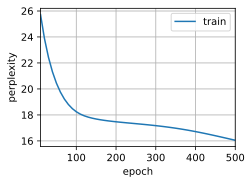

In [7]:
# 1. GRU 参数初始化
def get_gru_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape): return torch.randn(size=shape, device=device) * 0.01
    def three(): return (normal((num_inputs, num_hiddens)),
                        normal((num_hiddens, num_hiddens)),
                        torch.zeros(num_hiddens, device=device))
    W_xz, W_hz, b_z = three()  # 更新门
    W_xr, W_hr, b_r = three()  # 重置门
    W_xh, W_hh, b_h = three()  # 候选隐藏状态
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params: param.requires_grad_(True)
    return params

def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

# 2. GRU 前向计算
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(X @ W_xz + H @ W_hz + b_z)
        R = torch.sigmoid(X @ W_xr + H @ W_hr + b_r)
        H_tilda = torch.tanh(X @ W_xh + (R * H) @ W_hh + b_h)
        H = Z * H + (1 - Z) * H_tilda
        outputs.append(H @ W_hq + b_q)
    return torch.cat(outputs, dim=0), (H,)

# 3. 启动训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
model_gru = RNNModelScratch(vocab_size, num_hiddens, device, get_gru_params, init_gru_state, gru)
train_ch8(model_gru, train_iter, vocab, lr=1, num_epochs=500, device=device)

最终困惑度: 17.57, 28192.4 词元/秒 cuda:0
time traveller                                                  
traveller                                                  


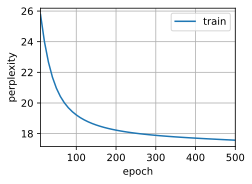

In [8]:
# 1. LSTM 参数初始化
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    # 输入门、遗忘门、输出门、候选记忆元各自的参数
    W_xi, W_hi, b_i = three()  # 输入门
    W_xf, W_hf, b_f = three()  # 遗忘门
    W_xo, W_ho, b_o = three()  # 输出门
    W_xc, W_hc, b_c = three()  # 候选记忆元

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 组合所有参数
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, 
              W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 2. 初始化隐藏状态 (LSTM 需要 H 和 C 两个状态)
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

# 3. 定义 LSTM 前向计算逻辑
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, 
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        # 核心公式计算
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        
        # 更新记忆元和隐藏状态
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        
        # 计算输出
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

# 4. 启动训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
model_lstm = RNNModelScratch(vocab_size, num_hiddens, device, get_lstm_params, 
                             init_lstm_state, lstm)

# 训练参数：lr=1, 训练500轮
train_ch8(model_lstm, train_iter, vocab, lr=1, num_epochs=500, device=device)